In [1]:
# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os


from shapely_conversion import convert
from shapely_utilities import *

import spiral as S
from spiral import calculate_point, calculate_point_contour

import fermat_spiral as FS

# optimization module
from optimization import optimization

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = S.execute(contour_family, distance)

    total_path.append(results)

    return total_path

In [4]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    s_path = S.execute(contour_family, distance)
            
    results = FS.convert_fermat(s_path,distance)

    total_path.append(results)

    return total_path

In [5]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = FS.fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return FS.combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [6]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance, fnc, optimize=False):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
    
    
    
    total_path = []
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:

            ext = optimization(list(sample(polygon.exterior,distance*2).coords), opt_reg, opt_smh, opt_spacing, False)

            ints = []

            for interior in polygon.interiors:
                ints.append(optimization(list(sample(interior,distance*2).coords), opt_reg, opt_smh, opt_spacing, False))

            polygon = Polygon(ext, holes=ints)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
     
    return total_path

<IPython.core.display.Javascript object>


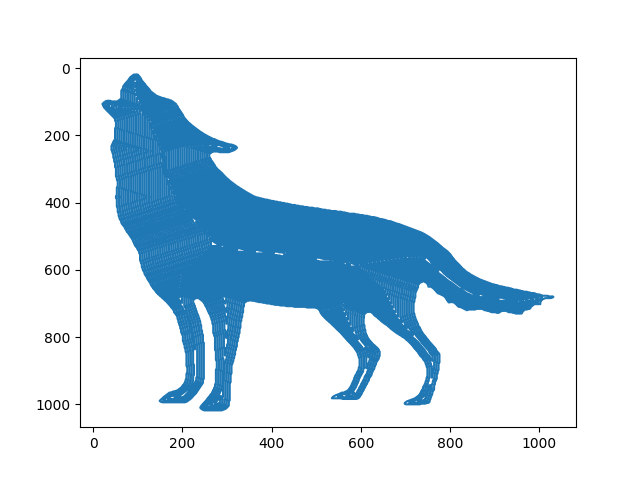

CPU times: user 10min 24s, sys: 259 ms, total: 10min 24s
Wall time: 10min 24s


In [7]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 5

# filename of image to process
filename = 'files/wolf.png'

# image should be in binary format
image = cv2.imread(filename,0)

# generate the un-connected fermat spiral output
# settings: simplify - True, optimize - False (flip this to true to see effect), optimize locally - True
#           penalize points for moving away from their original position: 1
#           penalize points for violating mid-point scheme: 5
#           spacing penalization is not implemented yet. The last term means nothing for now
results = execute(image, distance, generate_fermat_path, False)
# plot and show the path
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()

In [8]:
polygon = convert(image, 5)[0]

In [ ]:
ls = polygon.exterior


opt_reg = 1
opt_smh = 200
opt_spacing = 1
opt_local = True


# test optimization on input image
opt = optimization(list(ls.coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

<IPython.core.display.Javascript object>


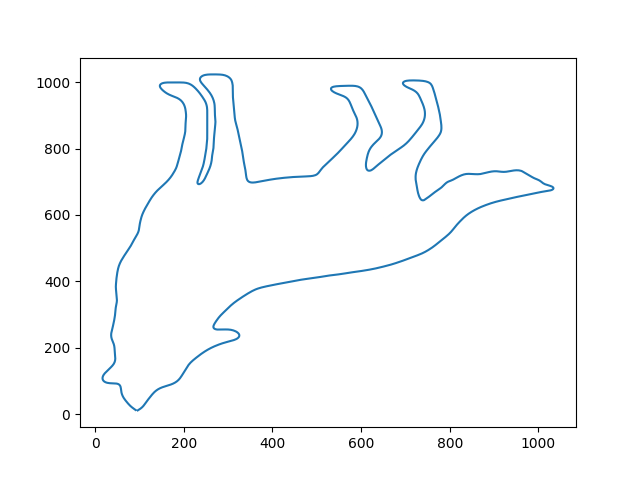

In [12]:
# test optimization on advanced image
# test optimization on input image
opt = optimization(list(sample(ls,3).coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [13]:
LineString(results).is_simple

True

In [9]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [10]:
# GCODE generation
# - this is used for converting the path into GCODE for the drawbot
# - applies an offset to each XY coordinate to avoid triggering the home flags repeatedly

x_offset = 2
y_offset = 2

# move the drawbot to a point
def command_move(p):
    return "G01 X" + str(p[0]+x_offset) + " Y" + str(p[1]+y_offset) + ";\n"

# move the pen up (drawbot specific)
def command_up():
    return "G01 Z0.5;\n"

# move the pen down (drawbot specific)
def command_down():
    return "G01 Z8.0;\n"

In [11]:
# GCODE generation
# - this takes the total path and creates a string of GCODE commands to follow the path
# - the expected input is a list of paths --> a single path should be in a list
def gcode(total_path, filename):
    
    # header function - home machine
    output = "G28 Z;\n"
    output += command_up()
    output += "G28 X Y;\n\n";
    
    for path in total_path:
        
        # move to p0
        output += command_move(path[0])
        
        # pen down
        output += command_down()
        
        # trace the path
        for p in path[1:]:
            output += command_move(p)
            
        # pen up
        output += command_up()
    
    # home machine
    output += "G28;\n"
    
    # print the number of commands
    print(len(output))
    
    # write the code to a gcode file
    f = open(filename, "w")
    f.write(output)
    f.close()
    
    # return the string (for debugging, not really needed)
    return output

In [12]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [ ]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute_backup(image, distance, fnc, simplify=True, optimize=False, optimize_local=True, opt_reg=1, opt_smh=200, opt_spacing=1):
    
    total_path = []
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        ext = optimization(list(sample(polygon.exterior,3).coords), opt_reg, opt_smh, opt_spacing, False)
        
        interiors = []
        
        for i in polygon.interiors:
            interiors.append(optimization(list(sample(polygon.exterior,3).coords), opt_reg, opt_smh, opt_spacing, False))
        
        
        
        # simplify the polygon to remove excess points - this helps with processing
        if simplify:
            polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # optimize each contour locally
        if optimize and optimize_local:
            for i in range(len(result)):
                result[i] = optimization(result[i], opt_reg, opt_smh, opt_spacing, optimize_local)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
            
    # optimize output path globally
    if optimize and not optimize_local:
        total_path = optimization(total_path, opt_reg, opt_smh, opt_spacing, optimize_local)
    
    return total_path